In [ ]:
'''
Applying this pipeline: clip embeddings -> pca -> lightgbm
'''
import torch
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor, plot_importance
import gc
import matplotlib.pyplot as plt
from model_data import SMAPELoss

In [2]:
train_data = pd.read_csv('train_clip_embed.csv')
X_train, y_train = train_data.drop('prices', axis=1).values, train_data['prices'].values

In [ ]:
# pipeline = Pipeline([('model', LGBMRegressor(objective='regression_l1',
#                                             metric='rmse',
#                                             n_estimators=2500,
#                                             learning_rate=0.01,
#                                             num_leaves=31,
#                                             # max_depth=8,
#                                             min_child_samples=20,
#                                             subsample=0.8,
#                                             colsample_bytree=0.8,
#                                             random_state=42,
#                                             n_jobs=-1,
#                                             device_type='gpu'))])
pipeline = Pipeline([('pca', KernelPCA(kernel='rbf')),
                     ('model', LGBMRegressor(objective='regression_l1',
                                            metric='rmse',
                                            n_estimators=2000,
                                            learning_rate=0.01,
                                            num_leaves=31,
                                            # max_depth=8,
                                            min_child_samples=20,
                                            subsample=0.8,
                                            colsample_bytree=0.8,
                                            random_state=42,
                                            n_jobs=-1,
                                            device_type='gpu'))])
# pipeline = Pipeline([('pca', PCA(n_components=0.95)),
#                      ('model', LGBMRegressor(objective='regression_l1',
#                                             metric='rmse',
#                                             n_estimators=2000,
#                                             learning_rate=0.01,
#                                             num_leaves=31,
#                                             # max_depth=8,
#                                             min_child_samples=20,
#                                             subsample=0.8,
#                                             colsample_bytree=0.8,
#                                             random_state=42,
#                                             n_jobs=-1,
#                                             device_type='gpu'))])
pipeline.fit(X_train, y_train)

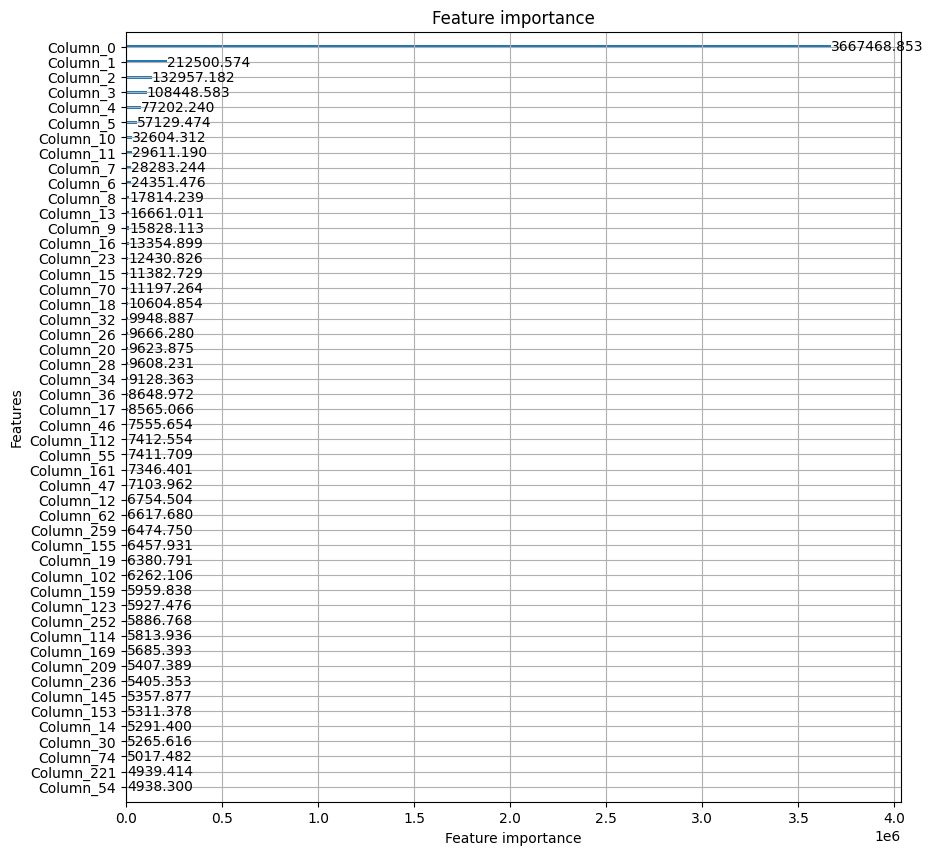

In [61]:
ax = plot_importance(pipeline[-1], importance_type='gain', max_num_features=50)
ax.get_figure().set_size_inches(10, 10)

In [62]:
y_preds = pipeline.predict(X_train)

C:\Users\DCL USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [63]:
metric_fn = SMAPELoss()
metric = metric_fn(torch.tensor(y_preds), torch.tensor(y_train))
metric

tensor(0.1218, dtype=torch.float64)

(array([31120., 20764., 10289.,  5162.,  2621.,  1641.,   880.,   634.,
          324.,    64.]),
 array([  1.13781264,  11.3847719 ,  21.63173116,  31.87869041,
         42.12564967,  52.37260893,  62.61956819,  72.86652744,
         83.1134867 ,  93.36044596, 103.60740522]),
 <BarContainer object of 10 artists>)

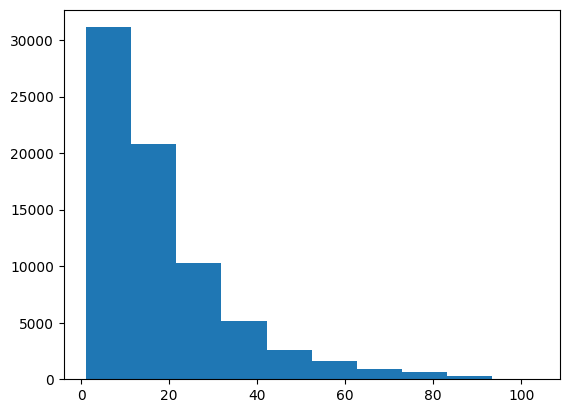

In [64]:
plt.hist(np.expm1(y_preds))

In [65]:
test_data = pd.read_csv('test_clip_embed.csv')
X_train = test_data.drop('prices', axis=1).values

In [66]:
y_preds_test = pipeline.predict(X_test)

C:\Users\DCL USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(array([30492., 22991., 10627.,  4919.,  2305.,  1472.,   912.,   748.,
          454.,    80.]),
 array([  1.21999271,  11.44260576,  21.66521881,  31.88783186,
         42.11044491,  52.33305796,  62.55567101,  72.77828406,
         83.00089711,  93.22351016, 103.44612321]),
 <BarContainer object of 10 artists>)

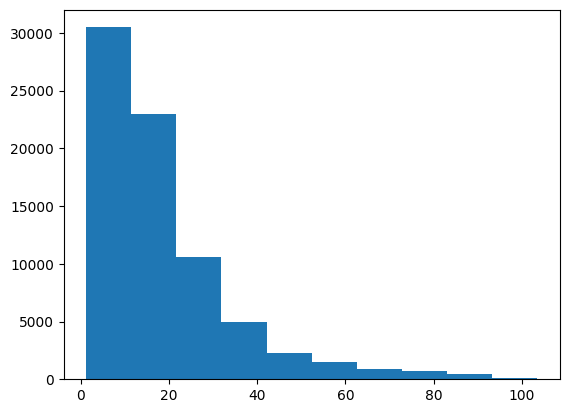

In [67]:
plt.hist(np.expm1(y_preds_test))

In [68]:
test_sub = pd.read_csv('student_resource/dataset/test_focused.csv', usecols=['sample_id'])
test_sub['price'] = np.expm1(y_preds_test)
test_sub

,sample_id,price
0,100179,19.413603
1,245611,13.928822
2,146263,17.389570
3,95658,3.472468
4,36806,12.961703
...,...,...
74995,93616,5.779132
74996,249434,10.793058
74997,162217,2.460904
74998,230487,10.697871


In [69]:
test_sub.to_csv('clip_pca.csv', index=False)